# Social Network Analysis: Final Project
### Names: Zoe Luther, Gwen Lynch, Rachel Lan

In [1]:
# !pip3 install torch-sparse
# !pip3 install torch-scatter
# !pip3 install torch_geometric

In [3]:
import csv
import pandas as pd
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import networkx as nx
import torch_geometric
import torch_scatter
import torch_sparse


from torch_geometric.loader import LinkNeighborLoader

from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import *

import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

Load dataset from [Spotify challenge](https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge/dataset_files): we opt to use the smaller versions of the available datasets due to resource constraints. 

In [4]:
df = pd.read_csv('log_mini.csv')
track_info = pd.read_csv('tf_mini.csv', index_col='track_id')
track_info = track_info[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key']]

# rescale feature information
track_id = track_info.index
data_to_scale = track_info.drop(columns=['track_id']) if 'track_id' in track_info.columns else track_info
std_scaler = StandardScaler()
scaled_data = std_scaler.fit_transform(data_to_scale)
track_info = pd.DataFrame(scaled_data, index=track_id, columns=data_to_scale.columns)

In [5]:
genres = pd.read_csv('data_by_genres.csv')
genres_numeric = genres[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key']]
genres_numeric.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key
0,0.979333,0.162883,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,6
1,0.494780,0.299333,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,5
2,0.762000,0.712000,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,7
3,0.651417,0.529093,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,7
4,0.676557,0.538961,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,7


# Generate 'genre' feature for all tracks

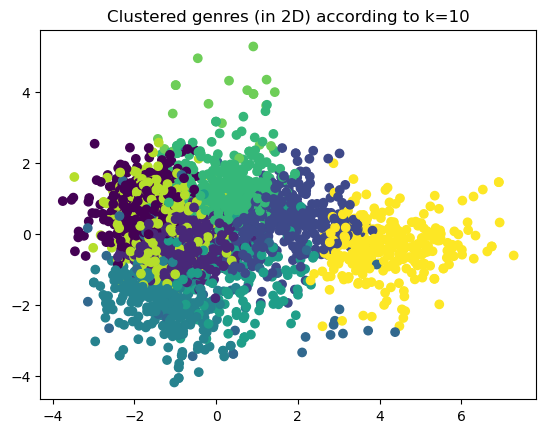

In [6]:
scaler = StandardScaler()
genres_numeric_scaled = scaler.fit_transform(genres_numeric)
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(genres_numeric_scaled)

pca = PCA(n_components=2)
genres_numeric_pca = pca.fit_transform(genres_numeric_scaled)

plt.scatter(genres_numeric_pca[:, 0], genres_numeric_pca[:, 1], c=clusters)
plt.title("Clustered genres (in 2D) according to k=10")
plt.show()

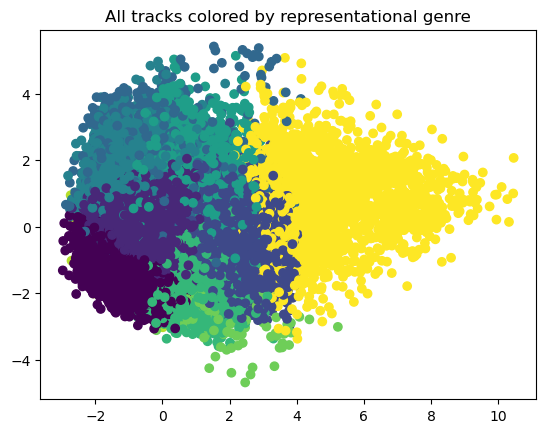

In [7]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
trf_pca = pca.fit_transform(scaled_data)

track_labels = kmeans.predict(scaled_data)

# visualization of predicted genre
plt.scatter(trf_pca[:, 0], trf_pca[:, 1], c=track_labels)
plt.title("All tracks colored by representational genre")
plt.show()

In [8]:
track_info['genre'] = track_labels
track_info.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre
track_id,,,,,,,,,,,
t_a540e552-16d4-42f8-a185-232bd650ea7d,0.752430,-1.275852,0.847631,-0.329484,-0.415877,-0.946756,-0.316225,1.501039,1.817189,-1.464642,6
t_67965da0-132b-4b1e-8a69-0ef99b32287c,2.412423,-0.725316,-2.342727,-0.329500,-0.239334,-1.575094,-0.287611,-0.883469,-0.520061,-1.464642,2
t_0614ecd3-a7d5-40a1-816e-156d5872a467,2.037889,-0.722973,-1.359077,-0.329500,-0.653912,-0.764466,-0.619176,-0.550264,0.969928,-1.464642,2
t_070a63a0-744a-434e-9913-a97b02926a29,0.530778,-0.358213,-0.610010,-0.329500,0.880555,-0.894309,-0.622410,-0.071690,1.506940,-1.464642,6
t_d6990e17-9c31-4b01-8559-47d9ce476df1,1.733399,-0.774619,0.384709,-0.329500,-0.092689,0.173968,-0.668686,-0.883469,0.302542,-1.464642,2


# GraphSAGE #2: via representative genre information

In [9]:
track_feat = track_info[['genre']]
track_feat = torch.from_numpy(track_feat.values).to(torch.float)
assert track_feat.size() == (50704, 1)

In [10]:
unique_session_id = df['session_id'].unique()
unique_session_id = pd.DataFrame(data={
    'session_id': unique_session_id,
    'mapped_session_id': pd.RangeIndex(len(unique_session_id)),
})
print("Mapping of session IDs to consecutive values:")
print("==========================================")
print(unique_session_id.head())
print()

Mapping of session IDs to consecutive values:
                               session_id  mapped_session_id
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e                  0
1  0_0000a72b-09ac-412f-b452-9b9e79bded8f                  1
2  0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a                  2
3  0_00016a3d-9076-4f67-918f-f29e3ce160dc                  3
4  0_00018b58-deb8-4f98-ac5e-d7e01b346130                  4



In [11]:
# Create a mapping from unique song indices to range [0, num_song_nodes):
unique_song_id = df['track_id_clean'].unique()
unique_song_id = pd.DataFrame(data={
    'track_id': track_info.index,
    'mapped_track_id': pd.RangeIndex(len(track_info)),
})
print("Mapping of song IDs to consecutive values:")
print("===========================================")
print(unique_song_id.head())

Mapping of song IDs to consecutive values:
                                 track_id  mapped_track_id
0  t_a540e552-16d4-42f8-a185-232bd650ea7d                0
1  t_67965da0-132b-4b1e-8a69-0ef99b32287c                1
2  t_0614ecd3-a7d5-40a1-816e-156d5872a467                2
3  t_070a63a0-744a-434e-9913-a97b02926a29                3
4  t_d6990e17-9c31-4b01-8559-47d9ce476df1                4


In [12]:
# Perform merge to obtain the edges from users and movies:
ratings_session_id = pd.merge(df['session_id'], unique_session_id, left_on='session_id', right_on='session_id', how='left')
ratings_session_id = torch.from_numpy(ratings_session_id['mapped_session_id'].values)

ratings_song_id = pd.merge(df['track_id_clean'], unique_song_id, left_on='track_id_clean', right_on='track_id', how='left')
ratings_song_id = torch.from_numpy(ratings_song_id['mapped_track_id'].values)

edge_index_session_to_song = torch.stack([ratings_session_id, ratings_song_id], dim=0)
assert edge_index_session_to_song.size() == (2, 167880)

print()
print("Final edge indices pointing from sessions to songs:")
print("=================================================")
print(edge_index_session_to_song)


Final edge indices pointing from sessions to songs:
tensor([[    0,     0,     0,  ...,  9999,  9999,  9999],
        [11160, 34125, 46575,  ..., 11509, 21450, 11505]])


In [13]:
data = HeteroData()

# Save node indices:
data["session"].node_id = torch.arange(len(unique_session_id))
data["song"].node_id = torch.arange(len(track_info))

# Add the node features and edge indices:
data["song"].x = track_feat
data["session", "rates", "song"].edge_index = edge_index_session_to_song

#  add the reverse edges from movies to users in order to let a GNN be able to pass messages in both directions.
data = T.ToUndirected()(data)

print(data)

HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 1],
  },
  (session, rates, song)={ edge_index=[2, 167880] },
  (song, rev_rates, session)={ edge_index=[2, 167880] }
)


In [14]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("session", "rates", "song"),
    rev_edge_types=("song", "rev_rates", "session"), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 1],
  },
  (session, rates, song)={
    edge_index=[2, 94013],
    edge_label=[40291],
    edge_label_index=[2, 40291],
  },
  (song, rev_rates, session)={ edge_index=[2, 94013] }
)

Validation data:
HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 1],
  },
  (session, rates, song)={
    edge_index=[2, 134304],
    edge_label=[50364],
    edge_label_index=[2, 50364],
  },
  (song, rev_rates, session)={ edge_index=[2, 134304] }
)


In [15]:
# Define seed edges:
edge_label_index = train_data["session", "rates", "song"].edge_label_index
edge_label = train_data["session", "rates", "song"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("session", "rates", "song"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  session={
    node_id=[5350],
    n_id=[5350],
  },
  song={
    node_id=[6426],
    x=[6426, 1],
    n_id=[6426],
  },
  (session, rates, song)={
    edge_index=[2, 11730],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[11730],
    input_id=[128],
  },
  (song, rev_rates, session)={
    edge_index=[2, 14033],
    e_id=[14033],
  }
)


In [16]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_session: Tensor, x_song: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_session = x_session[edge_label_index[0]]
        edge_feat_song = x_song[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_session * edge_feat_song).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two embedding matrices for users and movies:
        self.song_lin = torch.nn.Linear(input_size, hidden_channels)
        self.session_emb = torch.nn.Embedding(data["session"].num_nodes, hidden_channels)
        self.song_emb = torch.nn.Embedding(data["song"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        modified_list = [item for item in data.metadata()[0] if item != 'user']
        new_tuple = (modified_list, data.metadata()[1])

        self.gnn = to_hetero(self.gnn, metadata=new_tuple)

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "session": self.session_emb(data["session"].node_id),
          "song": self.song_lin(data["song"].x) + self.song_emb(data["song"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["session"],
            x_dict["song"],
            data["session", "rates", "song"].edge_label_index,
        )

        return pred

        
model = Model(input_size=1, hidden_channels=64)
print(model)

Model(
  (song_lin): Linear(in_features=1, out_features=64, bias=True)
  (session_emb): Embedding(10000, 64)
  (song_emb): Embedding(50704, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (session__rates__song): SAGEConv(64, 64, aggr=mean)
      (song__rev_rates__session): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (session__rates__song): SAGEConv(64, 64, aggr=mean)
      (song__rev_rates__session): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["session", "rates", "song"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 36.79it/s]


Epoch: 1.0, Loss: 0.5873


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 37.47it/s]


Epoch: 2.0, Loss: 0.4276


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 37.47it/s]


Epoch: 3.0, Loss: 0.3876


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 37.15it/s]


Epoch: 4.0, Loss: 0.3577


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 36.86it/s]


Epoch: 5.0, Loss: 0.3378


100%|█████████████████████████████████████████| 315/315 [00:08<00:00, 37.13it/s]

Epoch: 6.0, Loss: 0.3162


In [18]:
# Define the validation seed edges:
edge_label_index = val_data["session", "rates", "song"].edge_label_index
edge_label = val_data["session", "rates", "song"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("session", "rates", "song"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["session", "rates", "song"].edge_label_index.size(1) == 3 * 128
assert sampled_data["session", "rates", "song"].edge_label.min() >= 0
assert sampled_data["session", "rates", "song"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  session={
    node_id=[6305],
    n_id=[6305],
  },
  song={
    node_id=[8683],
    x=[8683, 1],
    n_id=[8683],
  },
  (session, rates, song)={
    edge_index=[2, 16751],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[16751],
    input_id=[384],
  },
  (song, rev_rates, session)={
    edge_index=[2, 26863],
    e_id=[26863],
  }
)


In [19]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["session", "rates", "song"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
pred_binary = np.array([0 if val <=0 else 1 for val in pred]).reshape(-1)

ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred_binary)
print()
print(f"Validation AUC: {auc:.4f}")
print(f"F1 score: {f1:.4f}")

100%|█████████████████████████████████████████| 132/132 [00:02<00:00, 52.01it/s]



Validation AUC: 0.8955
F1 score: 0.7117


# GraphSAGE #1: via all song feature components

In [20]:
track_feat = track_info[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key']]
track_feat = torch.from_numpy(track_feat.values).to(torch.float)
assert track_feat.size() == (50704, 10)


data["song"].x = track_feat
data["session", "rates", "song"].edge_index = edge_index_session_to_song

data = T.ToUndirected()(data)
print(data)

HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 10],
  },
  (session, rates, song)={ edge_index=[2, 167880] },
  (song, rev_rates, session)={ edge_index=[2, 167880] },
  (session, rev_rev_rates, song)={ edge_index=[2, 167880] }
)


In [21]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("session", "rates", "song"),
    rev_edge_types=("song", "rev_rates", "session"), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 10],
  },
  (session, rates, song)={
    edge_index=[2, 94013],
    edge_label=[40291],
    edge_label_index=[2, 40291],
  },
  (song, rev_rates, session)={ edge_index=[2, 94013] },
  (session, rev_rev_rates, song)={ edge_index=[2, 167880] }
)

Validation data:
HeteroData(
  session={ node_id=[10000] },
  song={
    node_id=[50704],
    x=[50704, 10],
  },
  (session, rates, song)={
    edge_index=[2, 134304],
    edge_label=[50364],
    edge_label_index=[2, 50364],
  },
  (song, rev_rates, session)={ edge_index=[2, 134304] },
  (session, rev_rev_rates, song)={ edge_index=[2, 167880] }
)


In [22]:
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("session", "rates", "song"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
# sampled_data = next(iter(train_loader))

# print("Sampled mini-batch:")
# print("===================")
# print(sampled_data)

model = Model(input_size=10, hidden_channels=64)
print(model)

Model(
  (song_lin): Linear(in_features=10, out_features=64, bias=True)
  (session_emb): Embedding(10000, 64)
  (song_emb): Embedding(50704, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (session__rates__song): SAGEConv(64, 64, aggr=mean)
      (song__rev_rates__session): SAGEConv(64, 64, aggr=mean)
      (session__rev_rev_rates__song): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (session__rates__song): SAGEConv(64, 64, aggr=mean)
      (song__rev_rates__session): SAGEConv(64, 64, aggr=mean)
      (session__rev_rev_rates__song): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["session", "rates", "song"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch}, Loss: {total_loss / total_examples:.4f}")


# Define the validation seed edges:
edge_label_index = val_data["session", "rates", "song"].edge_label_index
edge_label = val_data["session", "rates", "song"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("session", "rates", "song"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["session", "rates", "song"].edge_label_index.size(1) == 3 * 128
assert sampled_data["session", "rates", "song"].edge_label.min() >= 0
assert sampled_data["session", "rates", "song"].edge_label.max() <= 1

Device: 'cpu'


100%|█████████████████████████████████████████| 394/394 [00:14<00:00, 26.66it/s]


Epoch: 1.0, Loss: 1.1068


100%|█████████████████████████████████████████| 394/394 [00:15<00:00, 26.01it/s]


Epoch: 2.0, Loss: 1.1069


100%|█████████████████████████████████████████| 394/394 [00:15<00:00, 25.47it/s]


Epoch: 3.0, Loss: 1.1060


100%|█████████████████████████████████████████| 394/394 [00:15<00:00, 25.25it/s]


Epoch: 4.0, Loss: 1.1053


100%|█████████████████████████████████████████| 394/394 [00:15<00:00, 25.06it/s]


Epoch: 5.0, Loss: 1.1014


100%|█████████████████████████████████████████| 394/394 [00:15<00:00, 25.19it/s]

Epoch: 6.0, Loss: 1.1017
Sampled mini-batch:
HeteroData(
  session={
    node_id=[7203],
    n_id=[7203],
  },
  song={
    node_id=[9880],
    x=[9880, 10],
    n_id=[9880],
  },
  (session, rates, song)={
    edge_index=[2, 17416],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[17416],
    input_id=[384],
  },
  (song, rev_rates, session)={
    edge_index=[2, 33999],
    e_id=[33999],
  },
  (session, rev_rev_rates, song)={
    edge_index=[2, 18961],
    e_id=[18961],
  }
)


In [24]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["session", "rates", "song"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
pred_binary = np.array([0 if val <=0 else 1 for val in pred]).reshape(-1)

ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred_binary)
print()
print(f"Validation AUC: {auc:.4f}")
print(f"F1 score: {f1:.4f}")

100%|█████████████████████████████████████████| 132/132 [00:04<00:00, 31.02it/s]



Validation AUC: 0.4969
F1 score: 0.3436


# Linear regression model

In [25]:
df_merged = pd.merge(df, track_info, left_on='track_id_clean', right_on='track_id', how='left').drop(['skip_1', 'skip_2', 'skip_3'], axis=1)                                                                                 
# df_merged.info()

In [26]:
features = df_merged[['session_position', 'session_length', 'context_switch', 'no_pause_before_play', 'short_pause_before_play',
               'long_pause_before_play', 'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback', 'hour_of_day', 
               'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 
               'tempo', 'valence', 'key', 'genre']]

# Encode the target variable
target = df['not_skipped'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rounded_predictions = [0 if pred < 0.05 else 1 for pred in predictions]

auc = roc_auc_score(y_test, rounded_predictions)
f1 = f1_score(y_test, rounded_predictions)
print(f"AUC score: {auc}")
print(f"F1 score: {f1}")

AUC score: 0.5006677275208322
F1 score: 0.4986869591166816


# 2-layer MLP Model

In [27]:
features = df_merged[['session_position', 'session_length', 'context_switch', 'no_pause_before_play', 'short_pause_before_play',
               'long_pause_before_play', 'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback', 'hour_of_day', 
               'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 
               'tempo', 'valence', 'key', 'genre']]

target = df_merged['not_skipped'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)

# Evaluate the model
rounded_predictions = [0 if pred < 0.05 else 1 for pred in predictions]

auc = roc_auc_score(y_test, rounded_predictions)
f1 = f1_score(y_test, rounded_predictions)
print(f"AUC score: {auc}")
print(f"F1 score: {f1}")

AUC score: 0.5381963503578622
F1 score: 0.2169878658101356


# Baseline: via prior on historical listening rate

In [28]:
listening = pd.read_csv('log_mini.csv')
listening = listening.sample(frac = 1).reset_index(drop=True) #shuffle lines

train_listening = listening.iloc[:133880]
test_listening = listening.iloc[133880:150880]
validate_listening = listening.iloc[150880:]

In [29]:
all_sessions = set(listening['session_id'])
all_songs = set(listening['track_id_clean'])

print(f"Rate of positive edges: {len(listening[listening['not_skipped']==True]) / len(listening)}")
print(f"Number of positive edges: {len(listening[listening['not_skipped']==True])}")
print(f"Number of negative edges: {len(listening[listening['not_skipped']==False])}")

Rate of positive edges: 0.33288062902072907
Number of positive edges: 55884
Number of negative edges: 111996


In [30]:
track_info = pd.read_csv('tf_mini.csv')
track_info = track_info[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key']]

In [31]:
# construct graph representation based on training edge set:

G = nx.DiGraph()
G.add_nodes_from(all_sessions)

for song in all_songs:
    G.add_node(song, play_percentage=0)

for index, row in train_listening.iterrows():
    G.add_edge(row['session_id'], row['track_id_clean'])
    G[row['session_id']][row['track_id_clean']]['played'] = row['not_skipped']

for song in all_songs:
    edges = G.in_edges(nbunch=song)
    num_appearences = len(edges)
    num_played = 0
    for node1, node2 in edges:
        if G[node1][node2]['played']==True:
            num_played +=1 

    listen_rate = num_played/num_appearences if num_appearences > 0 else 0
    G.nodes[song]['play_percentage']= listen_rate

In [32]:
y_true = []
y_pred = []
for index, row in test_listening.iterrows():
    y_true.append(row['not_skipped'])
    y_pred.append(G.nodes[row['track_id_clean']]['play_percentage'] >= 0.5)

auc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"AUC score: {auc}")
print(f"F1 score: {f1}")

AUC score: 0.5171282553025017
F1 score: 0.24173428606031247
